In [1]:
# in the name of god 

In [91]:
import pandas as pd 
import numpy as np
from IPython.display import clear_output
import time
import pickle

import matplotlib.pyplot as plt
from matplotlib.cbook import flatten
import matplotlib.cm as cm
import matplotlib as matplotlib

def color_map_color(value, cmap_name='coolwarm', vmin=0, vmax=10):
    # norm = plt.Normalize(vmin, vmax)
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)  # PiYG
    rgb = cmap(norm(abs(value)))[:3]  # will return rgba, we take only first 3 so we get rgb
    color = matplotlib.colors.rgb2hex(rgb)
    return color

# Display figures inline in Jupyter notebook
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(15, 5)})

In [3]:
#prepare Dataset gyroscope
dfg=pd.read_csv('16\giroscopio_terra.csv')
dfg['ts']=pd.to_datetime(dfg.apply(lambda x:(round((x.uptimeNanos-dfg.uptimeNanos[0])/1000000)*1000000),axis=1))
dm=dfg['ts']
dfg=dfg.drop('uptimeNanos',1).drop('timestamp',1)
dfg=dfg.set_index('ts').rename(columns={'x': 'g-x','y': 'g-y','z': 'g-z'})
dfg.head(3)

,g-x,g-y,g-z
ts,,,
1970-01-01 00:00:00.000,-0.070372,0.000844,0.029619
1970-01-01 00:00:00.010,-0.058695,0.009130,0.024406
1970-01-01 00:00:00.032,0.006625,-0.002283,-0.015018


In [4]:
#prepare Dataset accelarator
dfa=pd.read_csv('16\\acelerometro_terra.csv')
dfa['ts']=dm
dfa=dfa.drop('uptimeNanos',1).drop('timestamp',1)
dfa=dfa.set_index('ts').rename(columns={'x': 'a-x','y': 'a-y','z': 'a-z'})
dfa.head(3)

,a-x,a-y,a-z
ts,,,
1970-01-01 00:00:00.000,-0.161602,0.120174,9.596758
1970-01-01 00:00:00.010,-0.122628,0.315638,9.425655
1970-01-01 00:00:00.032,-0.178777,0.330180,9.445955


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000022B89C1AC08>,
      dtype=object)

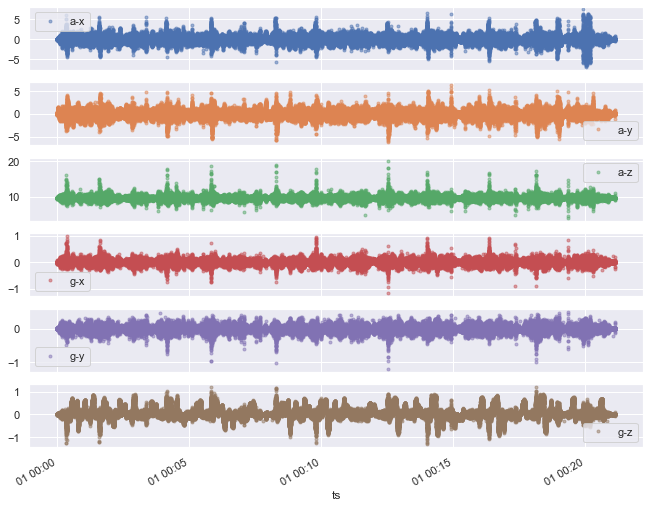

In [5]:
df = pd.concat([dfa, dfg], axis=1, join='outer')
df.plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)

In [6]:
#prepare Labeled dataset
dfl=pd.read_csv('16\\groundTruth.csv')
dfl['length']=dfl.en-dfl.st
lmean=dfl.length.mean()
lstd=dfl.length.std()

#extract the labels for clutering precision its for after clustering
def time_convertor(x):
    s,h,m=0,0,0
    s=round(x%60,2)
    m=int(x/60)
    h=int(m/60)
    m=m%60
    time=str(h)+':'+str(m)+':'+str(s)
    return pd.to_datetime('1970-01-01 '+time)

dfl['st_time']=dfl.apply(lambda x:time_convertor(x.st) ,axis=1 )
dfl['en_time']=dfl.apply(lambda x:time_convertor(x.en) ,axis=1 )
dfl=dfl.drop('st',1).drop('en',1).drop('length',1)
evented_label=list()
for i in range(len(dfl)):
    evented_label.append((dfl.iloc[i][0],dfl.iloc[i][1],dfl.iloc[i][2]))

In [20]:
#Dont RUN this part
#we should optimize M
#lengh of random event
from random import gauss
L=round(gauss(lmean,lstd)*50)
M=round(gauss(0.5,0.5)*50)

temp_event=list()
pointer=0
stop=False
#go on timeserise for event extraction
while stop!=True:
    clear_output(wait=True)
    M=round(gauss(1,0.5)*50)
    pointer=pointer + M
    #go forward till reach M
    L=round(gauss(lmean,lstd)*50)
    l_min=pointer-int(L/2)
    l_max=pointer+int(L/2)
    if (l_min<0):
        l_min=0
    if (l_max>len(df)):
        l_max=len(df)
        stop=True

    print('extraction ',l_max/len(df),' %  is complete')
    
    temp_event.append(df[l_min:l_max])



extraction  1.0  %  is complete


In [21]:
#Dont RUN this part
#calculate distance
from fastdtw import fastdtw
distance=list()
n=0
k=(len(temp_event))
k=k*k
t1=time.time()
for i,x in enumerate(temp_event):
    dumy=list()
    for j,y in enumerate(temp_event):
        clear_output(wait=True)
        n=n+1
        print('disstance calculatoin ',round((n/k)*100,4),' %  is complete')
        if (i<=j):
            continue
        else:
            dist,_=fastdtw(x,y)
            dumy.append(dist)
        
    distance.append(dumy)
t2=time.time()
print(round((t2-t1)/60) ,'min has time for calculaton distant')


disstance calculatoin  100.0  %  is complete
1221 min has time for calculaton distant


In [22]:
#Dont RUN this part
#clustering precision
n=0
k=len(temp_event)*len(evented_label)
labels_distance=list()

for tag,st,en in evented_label:
    dummy=list()
    for t_e in temp_event:
        clear_output(wait=True)
        n=n+1
        print('disstance calculatoin ',round((n/k)*100,2),' %  is complete')
        dist,_=fastdtw(df[st:en],t_e)
        dummy.append(dist)
    labels_distance.append((tag,dummy))


disstance calculatoin  100.0  %  is complete


In [24]:
#Save temp_event
with open("temp_event_on16.txt", "wb") as fp:
    pickle.dump(temp_event, fp)
    
#Save distance matrix
with open("distance_on16.txt", "wb") as fp:
    pickle.dump(distance, fp)
    
#Save labeds distance matrix
with open("labels_distance_on16.txt", "wb") as fp:
    pickle.dump(labels_distance, fp)
    

In [7]:
#load File , save the time of calculation
with open("temp_event_on16.txt", "rb") as fp:
    te = pickle.load(fp)
with open("distance_on16.txt", "rb") as fp:
    dc = pickle.load(fp)
with open("labels_distance_on16.txt", "rb") as fp:
    ld = pickle.load(fp)

In [8]:
#make it as matrix 
#full it with zero for squaring
from copy import deepcopy
def creat_Symmetric_matrix(file):  
    MTX=deepcopy(file)
    for i in range(len(MTX)):
        while len(MTX[i])!=len(MTX):
            MTX[i].append(0)
    #make it Symmetry from diameter
    arr=np.array(MTX)
    dis=np.array(MTX)
    for i in range(len(arr)):
        for j in range(len(arr)):
            if (i>j):
                dis[j][i]=arr[i][j]
    return dis
dis=creat_Symmetric_matrix(dc)

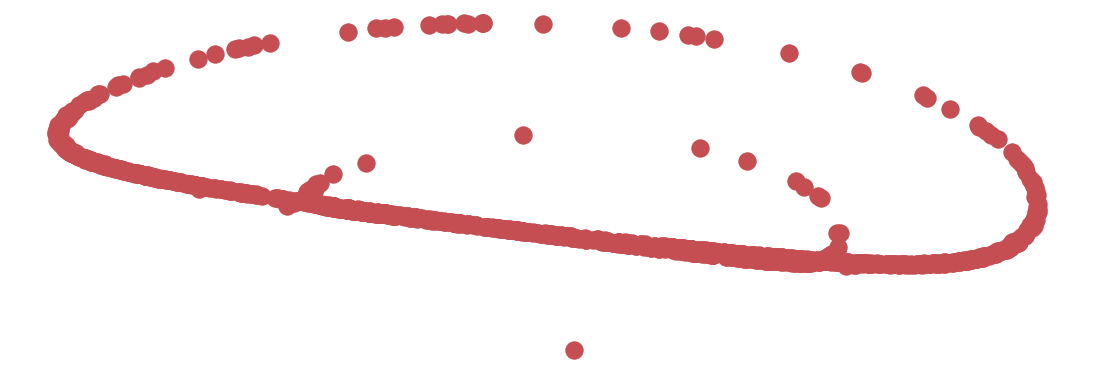

In [96]:
#PLOT GRAPH
import networkx as nx
G = G=nx.from_numpy_matrix(dis)
nx.draw(G,edge_color ='w', edge_cmap=plt.cm.winter ,node_color='r')

No handles with labels found to put in legend.


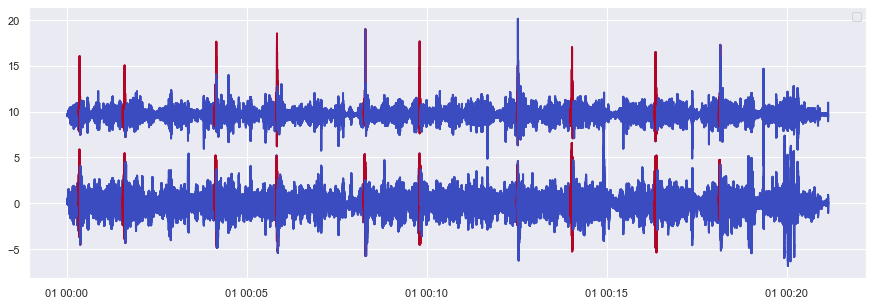

In [94]:
#initial clustering
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy

cluster = AgglomerativeClustering(n_clusters=4, affinity='precomputed', linkage = 'average').fit(dis)

plot_list=list()
for i,el in enumerate(te):
    plot_list.append((el,cluster.labels_[i]))
    
fig, ax = plt.subplots()

for el in plot_list:
    ax.plot(el[0], linestyle='-', linewidth=2,c=color_map_color(el[1]*10))
ax.legend();
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


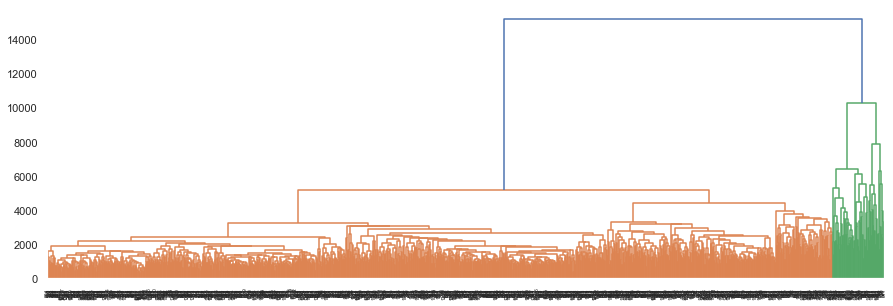

In [77]:
Z = hierarchy.linkage(dis, 'average')
plt.figure()
dn = hierarchy.dendrogram(Z)

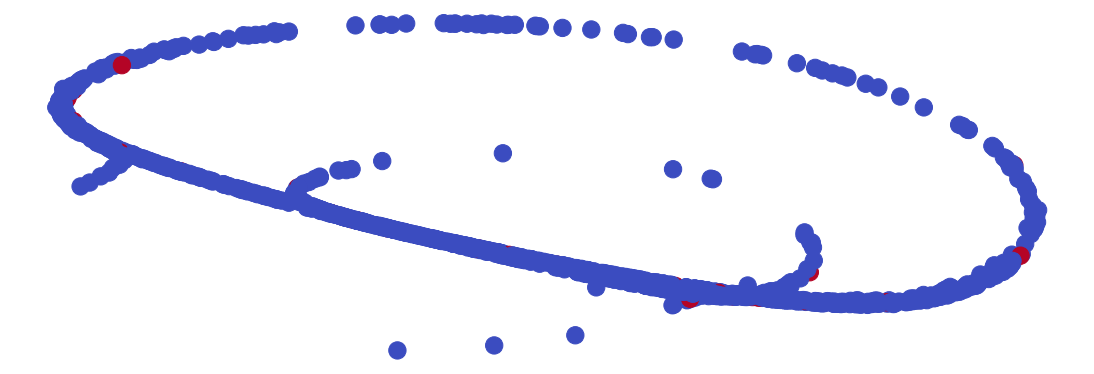

In [97]:
color_map = []
for cl in cluster.labels_:
    color_map.append(color_map_color(cl*10))

nx.draw(G,edge_color ='w', node_color=color_map)
plt.show()

In [58]:
#calculate the precision of clustering by labeled data 
exploratory_analysis=list()
for el in ld:
    midle_list=list()
    label_tag =el[0]
    label_distance=el[1].copy()
    label_distance.append(0)
    distance_matrix=dc.copy()
    distance_matrix.append(label_distance)
    DMX=creat_Symmetric_matrix(distance_matrix)
    Labels = AgglomerativeClustering(n_clusters=22, affinity='precomputed', linkage = 'average').fit(DMX).labels_

    #extract lable  and labele it from the item we put at the end
    for i , x in enumerate(Labels):
        if i!=(len(Labels)-1):
            if x==Labels[-1]:
                midle_list.append(i)
    exploratory_analysis.append([label_tag,midle_list])
actg=dict()
for ev,x in exploratory_analysis:
    if ev in actg:
        actg[ev].append(x)
    else:
        actg.update({ev:[x]})

In [113]:
#calculate the Probibility of being event of temp_event
Prob_threshold=0.2
precision=list()

for event_name in actg:
    flat_list=list(dict.fromkeys(flatten(actg[event_name])))
    dprecision=list()
    for S in flat_list:
        x=0
        Number=len(actg[event_name])
        for i in range(Number):
            if S in actg[event_name][i]:
                x=x+1
        Probability=x/Number
        if Probability > Prob_threshold:
            dprecision.append((S,Probability))
    precision.append((event_name,dprecision))

as you can see its the Selected event and their Probability

In [115]:
precision[1]

('curva_direita_agressiva',
 [(17, 0.8), (18, 0.8), (91, 0.8), (580, 0.8), (979, 0.8)])

as you can see its the Selected event and their Probability

In [61]:
precision[2]

('curva_esquerda_agressiva',
 [(242, 0.4),
  (243, 0.4),
  (244, 0.4),
  (346, 0.4),
  (347, 0.4),
  (749, 0.4),
  (1080, 0.4),
  (1081, 0.4),
  (1082, 0.4)])

but in this event if we want to get  good accurecy(becuse all of the detected event are non-aggressive) we have to optimize the number of the cluster and the linkage method that we chose

In [52]:
precision[3]

('troca_faixa_direita_agressiva',
 [(1133, 0.3333333333333333),
  (1134, 0.3333333333333333),
  (1135, 0.3333333333333333),
  (1130, 0.6666666666666666),
  (1194, 0.6666666666666666),
  (1195, 0.6666666666666666),
  (1196, 0.6666666666666666),
  (1201, 0.6666666666666666),
  (1202, 0.6666666666666666),
  (1204, 0.6666666666666666),
  (1205, 0.6666666666666666),
  (1212, 0.6666666666666666)])

In [126]:
#plot and optimize the number of the cluster and the linkage method
def Mean(dprecision):
    return np.mean(list(dict(dprecision).values()))

def Oploter(number_of_cluster , linkage_method):
    #calculate the precision of clustering by labeled data 
    exploratory_analysis=list()
    for el in ld:
        midle_list=list()
        label_tag =el[0]
        label_distance=el[1].copy()
        label_distance.append(0)
        distance_matrix=dc.copy()
        distance_matrix.append(label_distance)
        DMX=creat_Symmetric_matrix(distance_matrix)
        Labels = AgglomerativeClustering(n_clusters=number_of_cluster, affinity='precomputed', linkage = linkage_method).fit(DMX).labels_

        #extract lable  and labele it from the item we put at the end
        for i , x in enumerate(Labels):
            if i!=(len(Labels)-1):
                if x==Labels[-1]:
                    midle_list.append(i)
        exploratory_analysis.append([label_tag,midle_list])
    actg=dict()
    for ev,x in exploratory_analysis:
        if ev in actg:
            actg[ev].append(x)
        else:
            actg.update({ev:[x]})
    #calculate the Probibility of being event of temp_event
    Prob_threshold=0.1
    precision=list()
    for event_name in actg:
        flat_list=list(dict.fromkeys(flatten(actg[event_name])))
        dprecision=list()
        for S in flat_list:
            x=0
            Number=len(actg[event_name])
            for i in range(Number):
                if S in actg[event_name][i]:
                    x=x+1
            Probability=x/Number
            if Probability > Prob_threshold:
                dprecision.append((S,Probability))
        precision.append((event_name,len(dprecision),Mean(dprecision),dprecision))
    return precision


In [128]:
#linkage method complete
linkage_mth='complete'
Yc=list()
t1=time.time()
for num_cl in range(4,40):
    X=Oploter(num_cl,linkage_mth)
    Yc.append(X)
t2=time.time()
print(round((t2-t1)/60) ,'min has time for calculaton distant')

23 min has time for calculaton distant


No handles with labels found to put in legend.


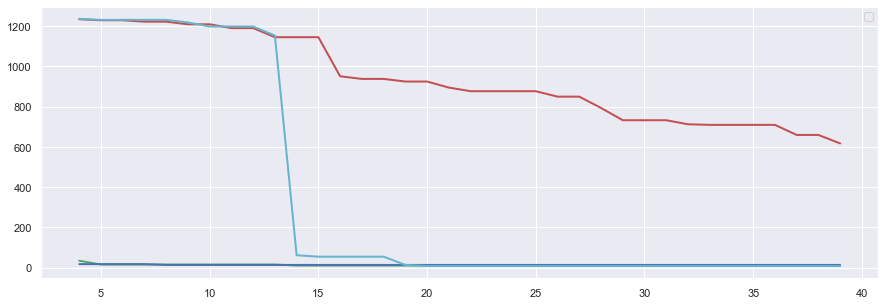

In [129]:
Yc_N1=[x[0][1] for x in Yc]
Yc_N2=[x[1][1] for x in Yc]
Yc_N3=[x[2][1] for x in Yc]
Yc_N4=[x[3][1] for x in Yc]
X = range(4,40)
fig, ax = plt.subplots()

ax.plot(X,Yc_N1, linestyle='-', linewidth=2,c='r')
ax.plot(X,Yc_N2, linestyle='-', linewidth=2,c='g')
ax.plot(X,Yc_N3, linestyle='-', linewidth=2,c='b')
ax.plot(X,Yc_N4, linestyle='-', linewidth=2,c='c')

ax.legend();
plt.show() 

No handles with labels found to put in legend.


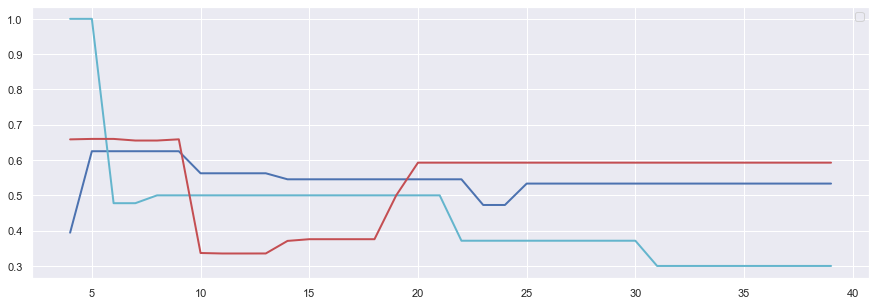

In [130]:
Yc_Q2=[x[1][2] for x in Yc]
Yc_Q3=[x[2][2] for x in Yc]

Yc_Q4=[x[3][2] for x in Yc]

X = range(4,40)
Xs = range(4,40)

fig, ax = plt.subplots()

ax.plot(X,Yc_Q2, linestyle='-', linewidth=2,c='b')
ax.plot(X,Yc_Q3, linestyle='-', linewidth=2,c='c')
ax.plot(Xs,Yc_Q4, linestyle='-', linewidth=2,c='r')

ax.legend();
plt.show()

In [179]:
#linkage method average
linkage_mth='average'
Ya=list()
t1=time.time()
for num_cl in range(4,40):
    X=Oploter(num_cl,linkage_mth)
    Ya.append(X)
t2=time.time()
print(round((t2-t1)/60) ,'min has time for calculaton distant')

23 min has time for calculaton distant


No handles with labels found to put in legend.


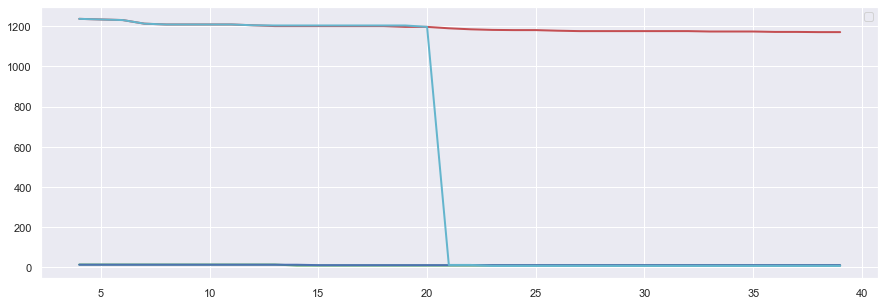

In [132]:
Ya_N1=[x[0][1] for x in Ya]
Ya_N2=[x[1][1] for x in Ya]
Ya_N3=[x[2][1] for x in Ya]
Ya_N4=[x[3][1] for x in Ya]
X = range(4,40)
fig, ax = plt.subplots()

ax.plot(X,Ya_N1, linestyle='-', linewidth=2,c='r')
ax.plot(X,Ya_N2, linestyle='-', linewidth=2,c='g')
ax.plot(X,Ya_N3, linestyle='-', linewidth=2,c='b')
ax.plot(X,Ya_N4, linestyle='-', linewidth=2,c='c')

ax.legend();
plt.show() 

No handles with labels found to put in legend.


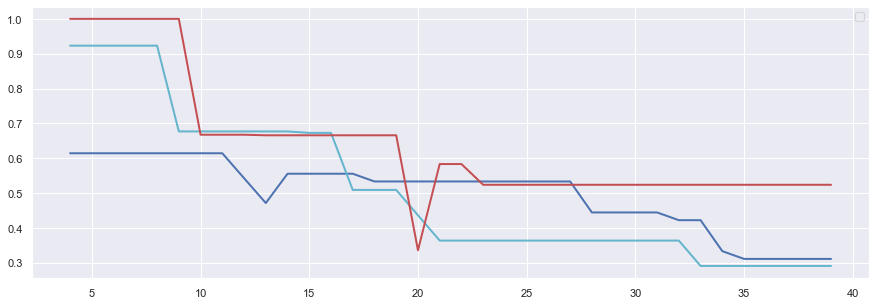

In [133]:
Ya_Q2=[x[1][2] for x in Ya]
Ya_Q3=[x[2][2] for x in Ya]
Ya_Q4=[x[3][2] for x in Ya]

X = range(4,40)
Xs = range(4,40)

fig, ax = plt.subplots()

ax.plot(X,Ya_Q2, linestyle='-', linewidth=2,c='b')
ax.plot(X,Ya_Q3, linestyle='-', linewidth=2,c='c')
ax.plot(Xs,Ya_Q4, linestyle='-', linewidth=2,c='r')
ax.legend();
plt.show() 

****between thee type of charts we can understands that the single method with n=5 for the pair event and n=22 for single event are sutable****

In [162]:
#now for detecting the non aggresive event we start search for that
#linkage method average
linkage_mth='average'
Yan=list()
t1=time.time()
for num_cl in range(50,1200,100):
    X=Oploter(num_cl,linkage_mth)
    Yan.append(X)
t2=time.time()
print(round((t2-t1)/60) ,'min has time for calculaton distant')

Yan_Q=[x[0][2] for x in Yan]
X=range(50,1200,100)
plt.plot(X,Yan_Q, linestyle='-', linewidth=2,c='b')
plt.show()

8 min has time for calculaton distant


17 min has time for calculaton distant


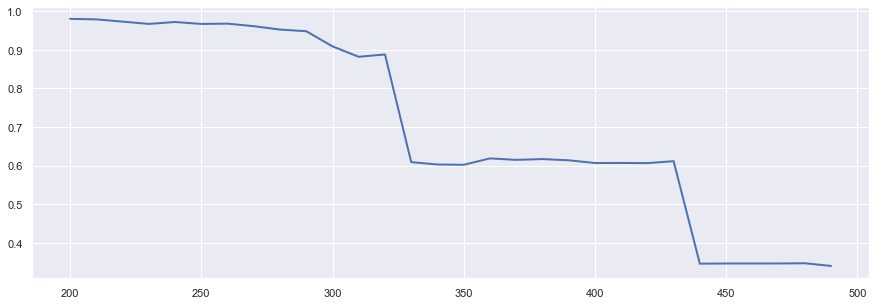

In [170]:
#now for detecting the non aggresive event we start search for that
#linkage method average
linkage_mth='average'
Yan=list()
t1=time.time()
for num_cl in range(200,500,10):
    X=Oploter(num_cl,linkage_mth)
    Yan.append(X)
t2=time.time()
print(round((t2-t1)/60) ,'min has time for calculaton distant')

Yan_Q=[x[0][2] for x in Yan]
X=range(200,500,10)
plt.plot(X,Yan_Q, linestyle='-', linewidth=2,c='b')
plt.show()

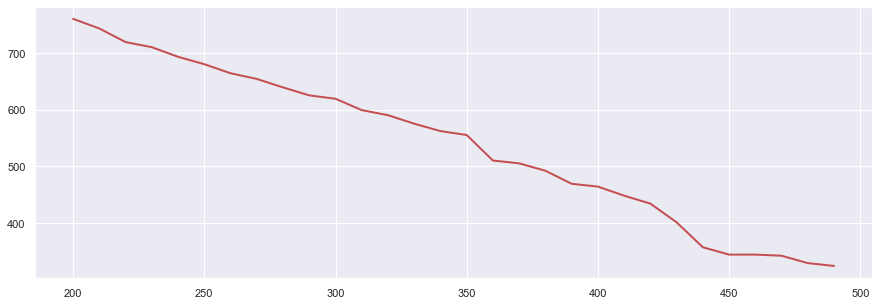

In [171]:
Yan_N=[x[0][1] for x in Yan]
X=range(200,500,10)
plt.plot(X,Yan_N, linestyle='-', linewidth=2,c='r')
plt.show()

18 min has time for calculaton distant


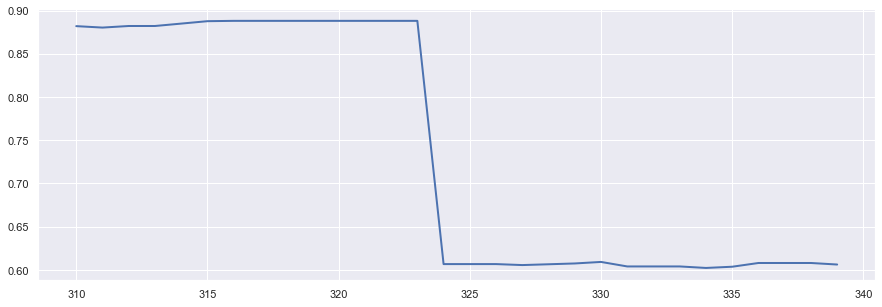

In [175]:
#now for detecting the non aggresive event we start search for that
#linkage method average
linkage_mth='average'
Yan=list()
t1=time.time()
for num_cl in range(310,340,1):
    X=Oploter(num_cl,linkage_mth)
    Yan.append(X)
t2=time.time()
print(round((t2-t1)/60) ,'min has time for calculaton distant')

Yan_Q=[x[0][2] for x in Yan]
X=range(310,340,1)
plt.plot(X,Yan_Q, linestyle='-', linewidth=2,c='b')
plt.show()

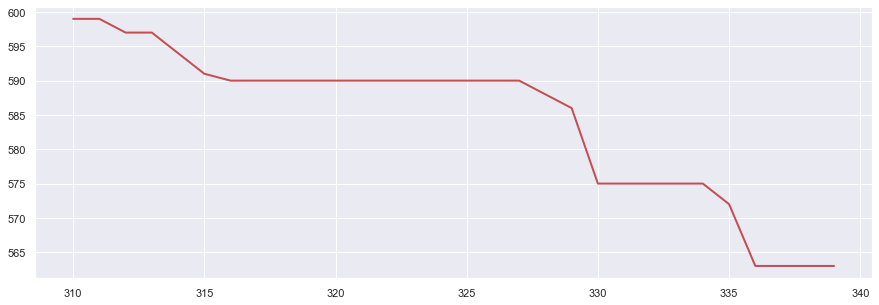

In [176]:
Yan_N=[x[0][1] for x in Yan]
X=range(310,340,1)
plt.plot(X,Yan_N, linestyle='-', linewidth=2,c='r')
plt.show()

In [177]:
Yan[323-310]

[('evento_nao_agressivo',
  590,
  0.888135593220339,
  [(0, 1.0),
   (1, 1.0),
   (2, 1.0),
   (3, 1.0),
   (4, 1.0),
   (5, 1.0),
   (6, 1.0),
   (7, 1.0),
   (8, 1.0),
   (9, 1.0),
   (11, 1.0),
   (13, 1.0),
   (27, 1.0),
   (28, 1.0),
   (29, 1.0),
   (39, 1.0),
   (40, 1.0),
   (41, 1.0),
   (42, 1.0),
   (43, 1.0),
   (47, 1.0),
   (48, 1.0),
   (49, 1.0),
   (50, 1.0),
   (56, 0.6666666666666666),
   (57, 0.6666666666666666),
   (58, 0.6666666666666666),
   (59, 1.0),
   (76, 0.6666666666666666),
   (83, 1.0),
   (84, 1.0),
   (86, 1.0),
   (94, 1.0),
   (114, 1.0),
   (115, 1.0),
   (121, 1.0),
   (122, 1.0),
   (123, 1.0),
   (125, 1.0),
   (126, 1.0),
   (131, 1.0),
   (132, 1.0),
   (133, 1.0),
   (134, 1.0),
   (135, 1.0),
   (136, 1.0),
   (137, 1.0),
   (138, 1.0),
   (139, 1.0),
   (140, 1.0),
   (141, 1.0),
   (142, 1.0),
   (147, 1.0),
   (152, 1.0),
   (153, 1.0),
   (154, 1.0),
   (155, 1.0),
   (156, 1.0),
   (157, 1.0),
   (158, 1.0),
   (159, 1.0),
   (160, 1.0),

In [197]:
OptimizeEvent=list()
OptimizeEvent.append(Ya[5-4][1])
OptimizeEvent.append(Ya[5-4][2])
OptimizeEvent.append(Ya[22-4][3])
OptimizeEvent.append(Yan[323-310][0])

#Save labeds distance matrix
with open("OptimizeLabeldEvent_on16.txt", "wb") as fp:
    pickle.dump(OptimizeEvent, fp)

In [198]:
#load File , save the time of calculation
with open("OptimizeLabeldEvent_on16.txt", "rb") as fp:
    oe = pickle.load(fp)

In [268]:
All_labeled_event=dict()
unlabel=list()
for el in oe:
    x=dict(el[3])
    for i in x:
        x[i]=(x[i],el[0])
    All_labeled_event.update(x)
for el in range(len(dis)):
    if not( el in All_labeled_event.keys()):
        unlabel.append(el)
labels_5 = AgglomerativeClustering(n_clusters=5, affinity='precomputed', linkage = 'average').fit(dis).labels_
labels_22 = AgglomerativeClustering(n_clusters=22, affinity='precomputed', linkage = 'average').fit(dis).labels_
labels_323 = AgglomerativeClustering(n_clusters=323, affinity='precomputed', linkage = 'average').fit(dis).labels_

In [265]:
for i,el in enumerate(labels_5):
    if i in unlabel:
        

1264

In [264]:
unlabel

[12,
 14,
 15,
 16,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 45,
 46,
 51,
 52,
 53,
 54,
 55,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 77,
 78,
 79,
 80,
 81,
 82,
 85,
 87,
 88,
 89,
 92,
 93,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 116,
 117,
 118,
 119,
 120,
 124,
 127,
 128,
 129,
 145,
 146,
 148,
 149,
 150,
 151,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 179,
 181,
 185,
 186,
 187,
 188,
 189,
 191,
 192,
 193,
 194,
 208,
 209,
 210,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 228,
 229,
 230,
 233,
 234,
 235,
 236,
 237,
 238,
 239,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 252,
 253,
 254,
 255,
 256,
 262,
 263,
 264,
 265,
 266,
 267,
 268,
 269,
 270,
 271,
 272,
 273,
 274,
 275,
 277,
 283,
 284,
 285,
 286,
 301,
 304,
 305,
 306,
 307,
 308,
 320,
 321,
 323,
 324,
 325,
 326,
 329,
 330,
 331